# 1. Содержание T_cashback_dataset
- 3 блока признаков — демография (возраст, пол, регион/город проживания), 12 × 3 финансовых метрик на каждую категорию (оборот, факт-активация, полученный кэшбек) за 6 месяцев (апрель – сентябрь).
- Много пропусков в «редких» категориях: аренда_авто, каршеринг, фастфуд и т. д.
- Пропуск в поле «активация» означает категории не было в выборе; 0/1 — была, но не выбрал / выбрал.

 Перед любым моделированием стоит агрегировать данные на уровень клиента, потому что стратегическое предложение формируется не на один конкретный месяц, а на горизонт «в ближайший месяц-два»



Импорты + чтение датасета:

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import ( StandardScaler,
                                    OrdinalEncoder, )
from sklearn.impute        import SimpleImputer
from sklearn.decomposition import PCA



raw = pd.read_csv('../data/T_cashback_dataset.csv')
print('Исходная форма датасета:', raw.shape)
raw


Исходная форма датасета: (59826, 57)


,ключ_клиента,регион_проживания,город_проживания,возраст,пол,месяц_покупок,оборот_аптеки,оборот_рестораны,оборот_одежда_и_обувь,оборот_автоуслуги,...,кэшбэк_развлечения,кэшбэк_жд_билеты,кэшбэк_образование,кэшбэк_дом_и_ремонт,кэшбэк_спорттовары,кэшбэк_животные,кэшбэк_цветы,кэшбэк_фастфуд,кэшбэк_каршеринг,кэшбэк_аренда_авто
0,1889,Москва,Москва,50,M,2023-04-01,18993.0,99900.0,3294.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1889,Москва,Москва,50,M,2023-05-01,37807.0,92424.0,NaN,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1889,Москва,Москва,50,M,2023-06-01,20791.0,124800.0,51246.0,67490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1889,Москва,Москва,50,M,2023-07-01,131129.0,18060.0,78120.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1889,Москва,Москва,50,M,2023-08-01,44096.0,198480.0,19080.0,147705.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59821,1005319581,Москва,Москва,37,NaN,2023-05-01,657.0,54375.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59822,1005319581,Москва,Москва,37,NaN,2023-06-01,NaN,128070.0,NaN,NaN,...,270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59823,1005319581,Москва,Москва,37,NaN,2023-07-01,5919.0,26085.0,NaN,NaN,...,1365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59824,1005319581,Москва,Москва,37,NaN,2023-08-01,1705.0,111690.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Перечисляем ключевые списки столбцов:

In [2]:
ID_COL    = 'ключ_клиента'
AGE_COLS   = 'возраст'
CAT_COLS  = 'пол'

MONEY_COLS = [c for c in raw.columns
              if ('оборот_' in c) or ('кэшбэк_' in c)]


Агрегируем данные к уровню клиента.
Получаем таблицу «клиент × признак»

In [3]:
agg_rules = {c: 'sum' for c in MONEY_COLS}
agg_rules[AGE_COLS] = 'median'

df_agg = (
    raw.groupby(ID_COL, sort=False)
        .agg(agg_rules)
        .join(raw.groupby(ID_COL)[CAT_COLS].first())
)

print('После агрегации:', df_agg.shape)
df_agg


После агрегации: (9971, 36)


,оборот_аптеки,оборот_рестораны,оборот_одежда_и_обувь,оборот_автоуслуги,оборот_супермаркеты,оборот_такси,оборот_красота,оборот_развлечения,оборот_жд_билеты,оборот_образование,...,кэшбэк_образование,кэшбэк_дом_и_ремонт,кэшбэк_спорттовары,кэшбэк_животные,кэшбэк_цветы,кэшбэк_фастфуд,кэшбэк_каршеринг,кэшбэк_аренда_авто,возраст,пол
ключ_клиента,,,,,,,,,,,,,,,,,,,,,
1889,315582.0,699384.0,246132.0,226745.0,2397229.0,520509.0,545595.0,236070.0,0.0,2955.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,M
2213,6885.0,0.0,31539.0,0.0,5386.0,51792.0,0.0,628125.0,168005.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,F
191765,79940.0,22653.0,386997.0,30538.0,642895.0,3882.0,63900.0,12090.0,0.0,0.0,...,0.0,0.0,0.0,471.0,0.0,0.0,0.0,0.0,47.0,F
256820,58929.0,329024.0,172842.0,796485.0,516286.0,46011.0,47280.0,113850.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1032.0,0.0,0.0,0.0,43.0,M
282534,41533.0,233108.0,207705.0,0.0,993545.0,114549.0,86391.0,61340.0,58012.0,0.0,...,0.0,0.0,0.0,978.0,0.0,0.0,6093.0,0.0,36.0,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002982745,29232.0,100044.0,209004.0,4686.0,400802.0,0.0,0.0,12000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,246.0,0.0,0.0,0.0,51.0,F
1002997975,76845.0,55023.0,141237.0,0.0,508353.0,11499.0,0.0,113700.0,0.0,39480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,M
1003172384,65594.0,374898.0,438291.0,33450.0,506364.0,216843.0,33327.0,61989.0,125985.0,127440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,F


Удаление строк с NaN в столбце `пол`

In [4]:
df_agg.dropna(subset=['пол'], inplace=True)
df_agg

,оборот_аптеки,оборот_рестораны,оборот_одежда_и_обувь,оборот_автоуслуги,оборот_супермаркеты,оборот_такси,оборот_красота,оборот_развлечения,оборот_жд_билеты,оборот_образование,...,кэшбэк_образование,кэшбэк_дом_и_ремонт,кэшбэк_спорттовары,кэшбэк_животные,кэшбэк_цветы,кэшбэк_фастфуд,кэшбэк_каршеринг,кэшбэк_аренда_авто,возраст,пол
ключ_клиента,,,,,,,,,,,,,,,,,,,,,
1889,315582.0,699384.0,246132.0,226745.0,2397229.0,520509.0,545595.0,236070.0,0.0,2955.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,M
2213,6885.0,0.0,31539.0,0.0,5386.0,51792.0,0.0,628125.0,168005.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,F
191765,79940.0,22653.0,386997.0,30538.0,642895.0,3882.0,63900.0,12090.0,0.0,0.0,...,0.0,0.0,0.0,471.0,0.0,0.0,0.0,0.0,47.0,F
256820,58929.0,329024.0,172842.0,796485.0,516286.0,46011.0,47280.0,113850.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1032.0,0.0,0.0,0.0,43.0,M
282534,41533.0,233108.0,207705.0,0.0,993545.0,114549.0,86391.0,61340.0,58012.0,0.0,...,0.0,0.0,0.0,978.0,0.0,0.0,6093.0,0.0,36.0,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002620484,213230.0,55515.0,45501.0,0.0,210879.0,60081.0,0.0,4500.0,0.0,0.0,...,0.0,0.0,0.0,240.0,0.0,0.0,0.0,0.0,59.0,M
1002982745,29232.0,100044.0,209004.0,4686.0,400802.0,0.0,0.0,12000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,246.0,0.0,0.0,0.0,51.0,F
1002997975,76845.0,55023.0,141237.0,0.0,508353.0,11499.0,0.0,113700.0,0.0,39480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,M


Находим весомые признаки.
«Доли» и «частоты» — часто более информативны для кластеризации, чем сами суммы.

In [5]:
df_agg['total_spend'] = df_agg[[c for c in df_agg.columns if 'оборот_' in c]].sum(axis=1)
df_agg['total_cashback'] = df_agg[[c for c in df_agg.columns if 'кэшбэк_' in c]].sum(axis=1)
df_agg['avg_cashback_rate'] = (df_agg['total_cashback'] / df_agg['total_spend']).replace([np.inf, -np.inf], np.nan).fillna(0)

df_agg = df_agg[df_agg['total_spend'] > 0].copy()

# Создаём признаки долей по категориям
for col in df_agg.columns:
    if col.startswith('оборот_'):
        share_col = 'share_' + col.replace('оборот_', '')
        df_agg[share_col] = df_agg[col] / df_agg['total_spend'].replace({0: np.nan})

share_cols = [c for c in df_agg.columns if c.startswith('share_')]
df_agg['dominant_category'] = df_agg[share_cols].idxmax(axis=1).str.replace('share_', '')

# Разнообразие трат
df_agg['diversity_score'] = df_agg[share_cols].std(axis=1)
df_agg['n_active_categories'] = (df_agg[share_cols] > 0).sum(axis=1)
df_agg['supermarket_share'] = df_agg.get('share_супермаркеты', 0)

# Подготовка к кластеризации
cluster_features = [
    'total_spend', 'total_cashback', 'avg_cashback_rate',
    'supermarket_share', 'diversity_score', 'n_active_categories', 'возраст', 'пол'
]
df_agg[cluster_features]

,total_spend,total_cashback,avg_cashback_rate,supermarket_share,diversity_score,n_active_categories,возраст,пол
ключ_клиента,,,,,,,,
1889,5966782.0,137226.0,0.022998,0.401762,0.095635,14,50.0,M
2213,891732.0,63120.0,0.070784,0.006040,0.172763,6,52.0,F
191765,1355680.0,19602.0,0.014459,0.474223,0.126743,13,47.0,F
256820,2612199.0,42861.0,0.016408,0.197644,0.084214,12,43.0,M
282534,2826693.0,26613.0,0.009415,0.351487,0.094742,13,36.0,M
...,...,...,...,...,...,...,...,...
1002620484,888957.0,12234.0,0.013762,0.237221,0.085198,9,59.0,M
1002982745,1011471.0,19401.0,0.019181,0.396257,0.106563,9,51.0,F
1002997975,1108760.0,13563.0,0.012233,0.458488,0.112358,10,40.0,M


### ColumnTransformer (пайплайн препроцессинга)
Общая цель пайплайна preprocess:
- Подготовить признаки для подачи в модель;
- числовые значения масштабировать;
- категориальные — закодировать;


In [6]:
num_cols = [
    'total_spend', 'total_cashback', 'avg_cashback_rate',
    'supermarket_share', 'diversity_score', 'n_active_categories',
    'возраст'
]

preprocess = ColumnTransformer(
    transformers=[
        # Числовые признаки
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), num_cols),

        # Пол
        ('gender', Pipeline([
            ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encode', OrdinalEncoder(categories=[['F', 'M', 'unknown']]))
        ]), [CAT_COLS])
    ],
    remainder='drop'
)


### Препроцессинг

In [7]:
X = preprocess.fit_transform(df_agg[cluster_features])
print('Форма после препроцессинга:', X.shape)
X


Форма после препроцессинга: (9538, 8)


array([[ 1.7421206 ,  3.36255616, -0.02472224, ...,  1.0169005 ,
         1.66296266,  1.        ],
       [-0.67867111,  1.10794551,  0.14441702, ..., -2.13654077,
         1.8867179 ,  0.        ],
       [-0.45736856, -0.21605182, -0.05494719, ...,  0.62272034,
         1.32732979,  0.        ],
       ...,
       [-0.57514906, -0.39978314, -0.06282833, ..., -0.55982013,
         0.54418645,  1.        ],
       [ 0.11916485, -0.42661723, -0.08862283, ...,  1.41108066,
        -0.91022262,  0.        ],
       [ 0.0470107 , -0.45409022, -0.08885014, ...,  1.0169005 ,
         0.76794169,  1.        ]], shape=(9538, 8))

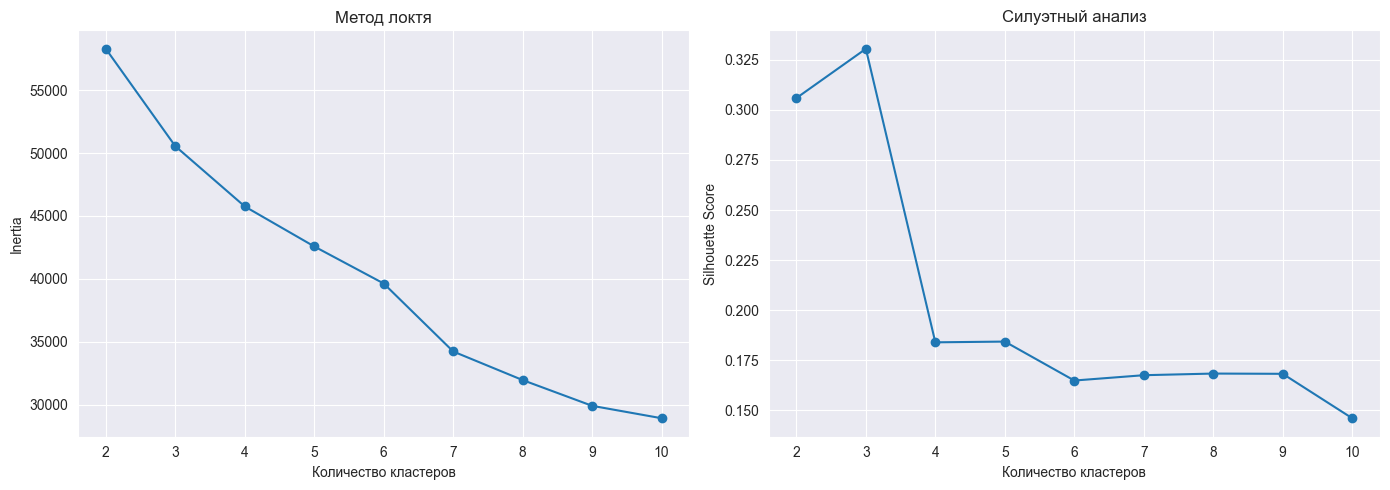

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))

# Визуализация обеих метрик
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Метод локтя
axs[0].plot(K_range, inertia, marker='o')
axs[0].set_xlabel('Количество кластеров')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Метод локтя')
axs[0].grid(True)

# Silhouette Score
axs[1].plot(K_range, silhouettes, marker='o')
axs[1].set_xlabel('Количество кластеров')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_title('Силуэтный анализ')
axs[1].grid(True)

plt.tight_layout()
plt.show()


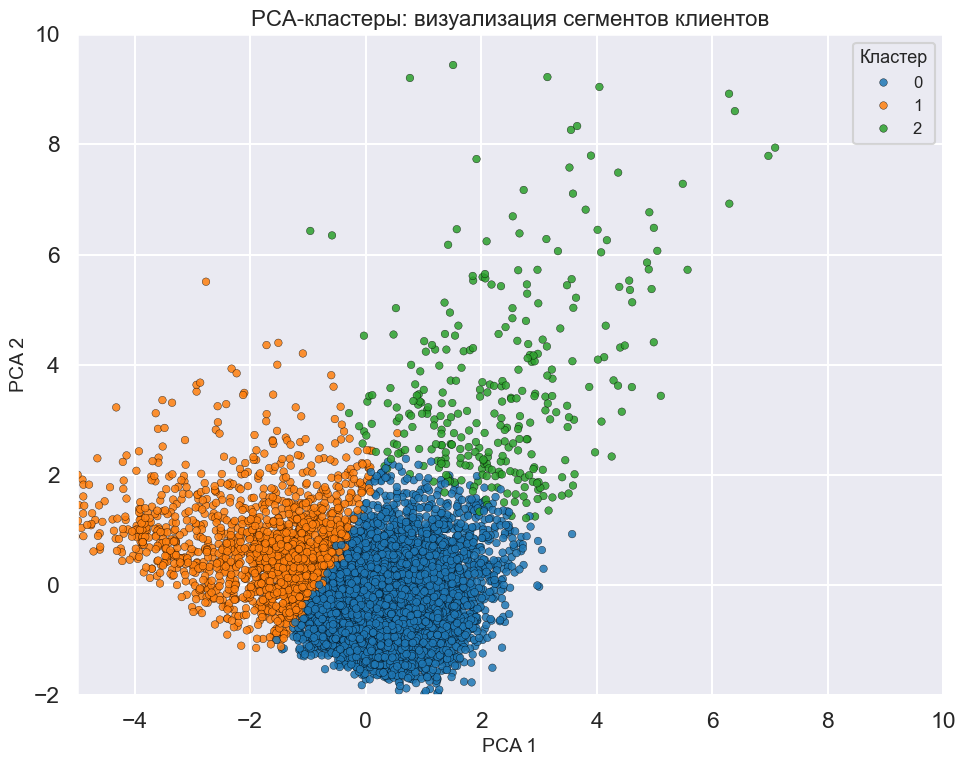

In [9]:
from sklearn.cluster import KMeans
import seaborn as sns

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# PCA проекция
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df_plot = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_plot['Кластер'] = labels

sns.set(style="darkgrid", context="talk")

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot,
    x='PCA1', y='PCA2',
    hue='Кластер',
    palette='tab10',
    s=30,
    alpha=0.85,
    edgecolor='black',
    linewidth=0.3
)

plt.xlim(-5, 10)
plt.ylim(-2, 10)

plt.title('PCA-кластеры: визуализация сегментов клиентов', fontsize=16)
plt.xlabel('PCA 1', fontsize=14)
plt.ylabel('PCA 2', fontsize=14)
plt.legend(title='Кластер', fontsize=12, title_fontsize=13, loc='best')
plt.tight_layout()
plt.show()


In [10]:
df_clustered = df_agg.copy() # подтягиваем всевозможные признаки для подсчетов (изначальные + кастомные)
df_clustered['cluster'] = labels

In [11]:
print("Размер каждого кластера:")
print(df_clustered['cluster'].value_counts().sort_index())


Размер каждого кластера:
cluster
0    7256
1    1955
2     327
Name: count, dtype: int64


In [12]:
cluster_summary = df_clustered.groupby('cluster').agg({
    'total_spend': 'mean',
    'total_cashback': 'mean',
    'avg_cashback_rate': 'mean',
    'supermarket_share': 'mean',
    'diversity_score': 'mean',
    'n_active_categories': 'mean',
    'возраст': 'mean'
}).round(2)

# Переименование для удобства
cluster_summary = cluster_summary.rename(columns={
    'total_spend': 'Средний оборот',
    'total_cashback': 'Средний кэшбэк',
    'avg_cashback_rate': 'Ставка кэшбэка',
    'supermarket_share': 'Доля трат супермаркеты',
    'diversity_score': 'Разнообразие трат',
    'n_active_categories': 'Активные категории',
    'возраст': 'Средний возраст'
})

display(cluster_summary)


,Средний оборот,Средний кэшбэк,Ставка кэшбэка,Доля трат супермаркеты,Разнообразие трат,Активные категории,Средний возраст
cluster,,,,,,,
0,2275524.32,23691.08,0.01,0.27,0.10,12.18,34.11
1,1302054.12,19661.56,0.10,0.47,0.16,8.43,38.64
2,9233138.18,135643.92,0.02,0.18,0.15,12.49,36.92


 #### Кластер 0
- Средний оборот: ~2.28 млн
- Ставка кэшбэка: всего 1%
- Разнообразие: низкое
- Супермаркеты: 27%
- Интерпретация: базовые повседневные клиенты, которые много тратят, но не "охотятся" за кэшбэком, пользуются немногочисленными категориями.

#### Кластер 1
- Средний оборот: ~1.3 млн
- Ставка кэшбэка: 10% (самая высокая)
- Разнообразие: выше среднего
- Супермаркеты: почти 47%
- Интерпретация: экономные пользователи, активно ищущие выгоду, скорее всего чаще участвуют в промо, много покупают в супермаркетах.

#### Кластер 2
- Средний оборот: ~9.2 млн
- Ставка кэшбэка: умеренная 2%
- Разнообразие и категории: средние
- Супермаркеты: 18%
- Интерпретация: VIP-клиенты — тратят много, но не гонятся за кэшбэком, могут тратить в других более дорогих категориях.

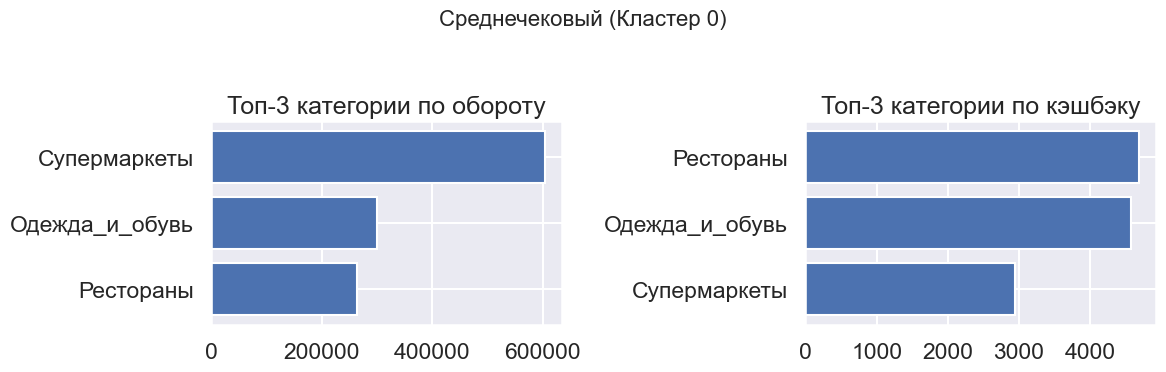

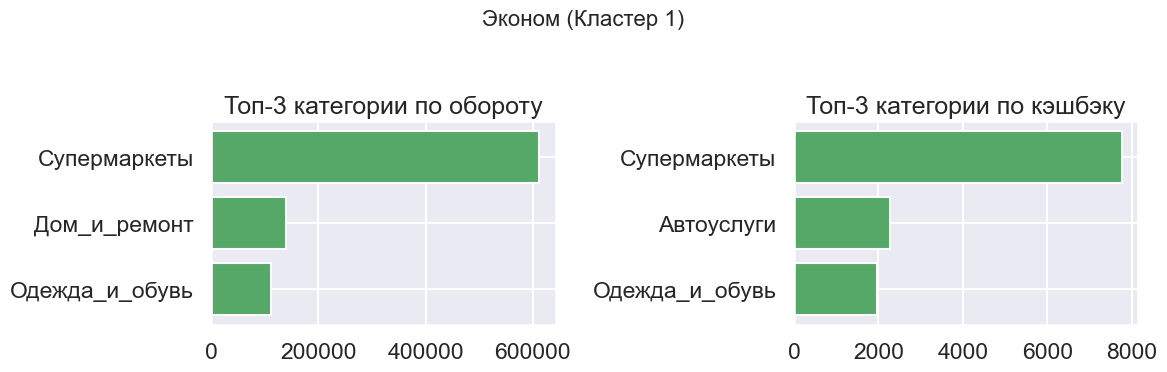

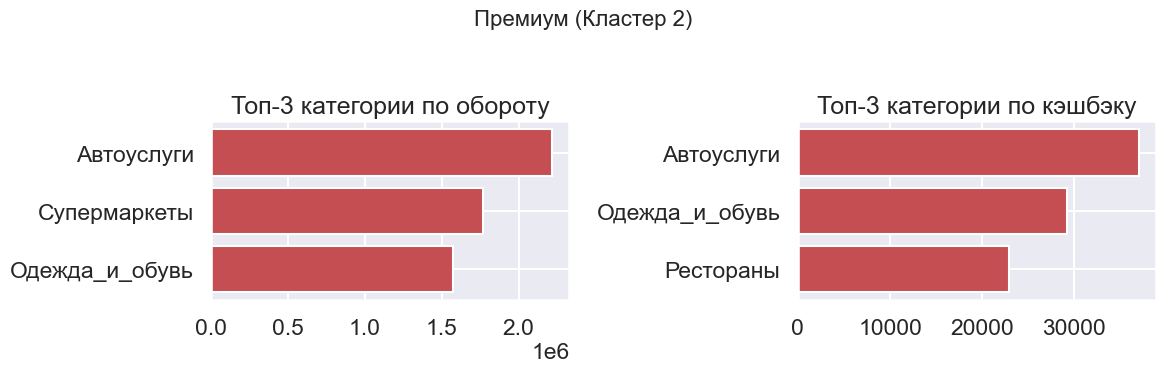

In [13]:
import matplotlib.pyplot as plt

cluster_names = {
    0: "Среднечековый",
    1: "Эконом",
    2: "Премиум"
}

colors = ['#4c72b0', '#55a868', '#c44e52']

spend_cols = [col for col in df_clustered.columns if col.startswith('оборот_')]
cashback_cols = [col for col in df_clustered.columns if col.startswith('кэшбэк_')]

for cluster_id in sorted(df_clustered['cluster'].unique()):
    df_sub = df_clustered[df_clustered['cluster'] == cluster_id]

    # Средние значения
    top_spend = df_sub[spend_cols].mean().sort_values(ascending=False).head(3)
    top_cashback = df_sub[cashback_cols].mean().sort_values(ascending=False).head(3)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"{cluster_names[cluster_id]} (Кластер {cluster_id})", fontsize=16)

    # Оборот
    axes[0].barh(
        [col.replace('оборот_', '').capitalize() for col in top_spend.index],
        top_spend.values,
        color=colors[cluster_id]
    )
    axes[0].set_title("Топ-3 категории по обороту")
    axes[0].invert_yaxis()

    # Кэшбэк
    axes[1].barh(
        [col.replace('кэшбэк_', '').capitalize() for col in top_cashback.index],
        top_cashback.values,
        color=colors[cluster_id]
    )
    axes[1].set_title("Топ-3 категории по кэшбэку")
    axes[1].invert_yaxis()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


#### Предсказывание сегмента для нового клиента

In [14]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df_clustered[cluster_features].copy()
y = df_clustered['cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

cat_features = ['пол']

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    verbose=50,
    random_seed=42
)
model.fit(train_pool)

y_pred = model.predict(test_pool)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



0:	learn: 0.9462542	total: 60.8ms	remaining: 18.2s
50:	learn: 0.0822953	total: 124ms	remaining: 604ms
100:	learn: 0.0490428	total: 185ms	remaining: 365ms
150:	learn: 0.0364191	total: 247ms	remaining: 244ms
200:	learn: 0.0294940	total: 309ms	remaining: 152ms
250:	learn: 0.0251952	total: 372ms	remaining: 72.6ms
299:	learn: 0.0218624	total: 436ms	remaining: 0us
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1452
           1       0.97      0.98      0.97       391
           2       1.00      0.86      0.93        65

    accuracy                           0.99      1908
   macro avg       0.99      0.94      0.96      1908
weighted avg       0.99      0.99      0.99      1908

[[1442   10    0]
 [   9  382    0]
 [   7    2   56]]


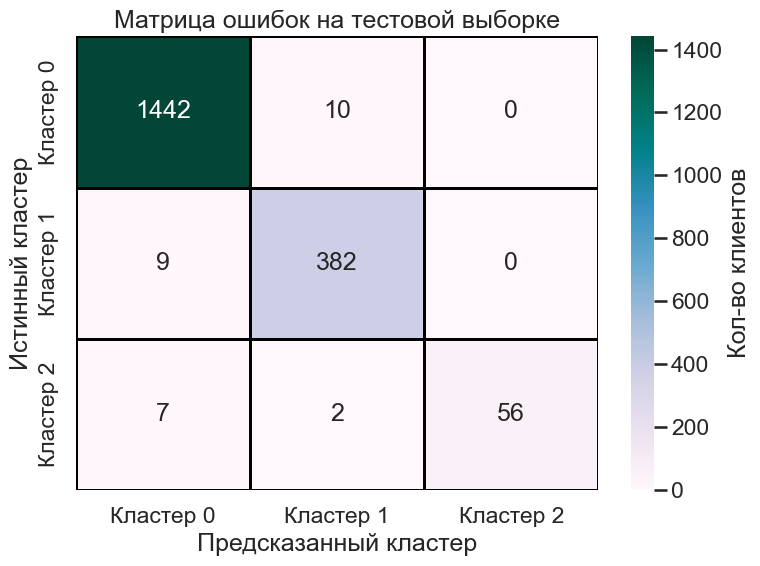

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

labels = [f'Кластер {i}' for i in sorted(set(y))]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Кол-во клиентов'}, linewidths=1, linecolor='black')

plt.title('Матрица ошибок на тестовой выборке')
plt.xlabel('Предсказанный кластер')
plt.ylabel('Истинный кластер')
plt.tight_layout()
plt.show()




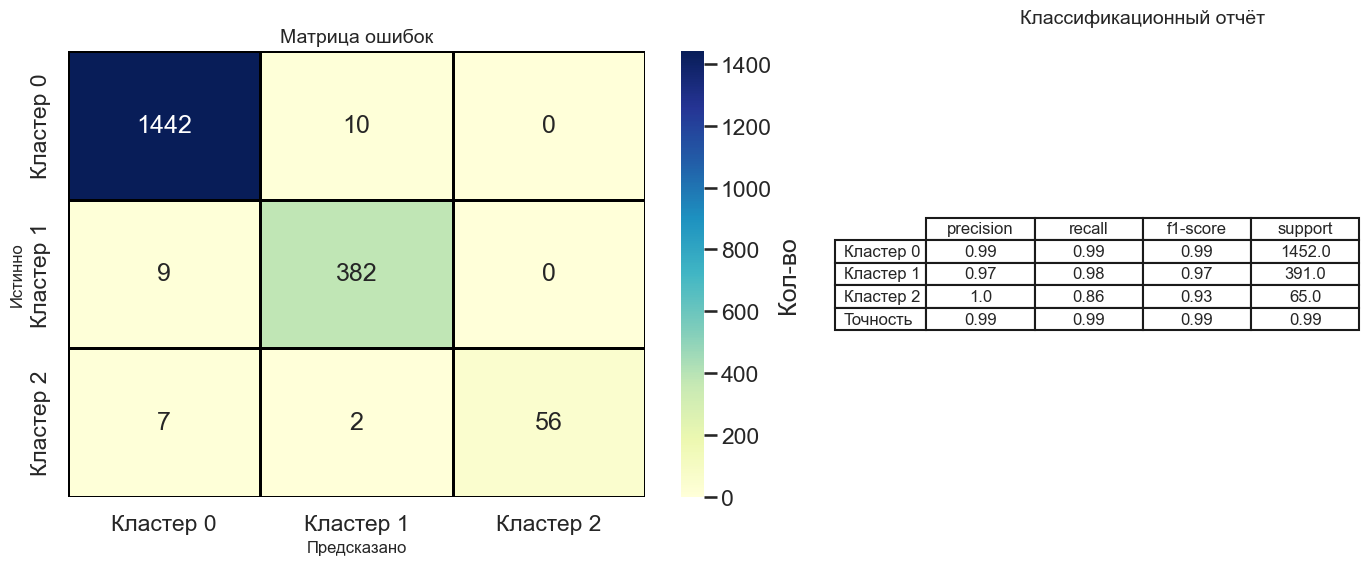

In [16]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)

metrics_df = report_df.loc[['0', '1', '2', 'accuracy']].rename(index={
    '0': 'Кластер 0',
    '1': 'Кластер 1',
    '2': 'Кластер 2',
    'accuracy': 'Точность'
})

fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=metrics_df.index[:-1],
            yticklabels=metrics_df.index[:-1],
            cbar_kws={'label': 'Кол-во'}, linewidths=1, linecolor='black', ax=axs[0])
axs[0].set_title('Матрица ошибок', fontsize=14)
axs[0].set_xlabel('Предсказано', fontsize=12)
axs[0].set_ylabel('Истинно', fontsize=12)

axs[1].axis('off')
table = axs[1].table(
    cellText=metrics_df.values,
    rowLabels=metrics_df.index,
    colLabels=metrics_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)
axs[1].set_title("Классификационный отчёт", fontsize=14, pad=20)

plt.tight_layout()
plt.show()


In [43]:
df_clustered[cluster_features].to_csv("clustered_features.csv")

In [17]:
df_synth = pd.read_csv("../data/synthetic_clients_500_cleaned.csv")
df_synth.set_index('ключ_клиента', inplace=True)
df_synth


,total_spend,total_cashback,avg_cashback_rate,supermarket_share,diversity_score,n_active_categories,возраст,пол
ключ_клиента,,,,,,,,
1,5132758.0,7420.0,0.011685,0.213917,0.162168,16,30,M
2,1774402.0,44912.0,0.011760,0.352827,0.123586,4,34,F
3,2774705.0,27288.0,0.052476,0.169677,0.156641,8,20,M
4,2040722.0,57412.0,0.029233,0.163246,0.120173,8,39,F
5,1560114.0,43570.0,0.036070,0.203504,0.147466,7,39,F
...,...,...,...,...,...,...,...,...
496,2254756.0,7193.0,0.061366,0.454697,0.079795,14,40,F
497,4525880.0,0.0,0.042814,0.176501,0.062480,13,14,M
498,2297066.0,62310.0,0.023300,0.295191,0.081247,9,16,F


#### Предсказание кластеров для "синтетических" клиентов

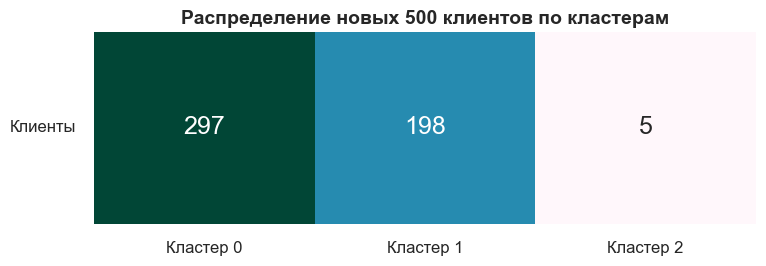

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import Pool

X_new = df_synth[[
    'total_spend', 'total_cashback', 'avg_cashback_rate',
    'supermarket_share', 'diversity_score', 'n_active_categories',
    'возраст', 'пол'
]].copy()
X_new['пол'] = X_new['пол'].astype(str)

new_pool = Pool(X_new, cat_features=['пол'])
df_synth['predicted_cluster'] = model.predict(new_pool).astype(int)

cluster_counts = df_synth['predicted_cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 3))
ax = sns.heatmap(
    cluster_counts.values.reshape(1, -1),
    annot=True,
    fmt="d",
    cmap="PuBuGn",
    xticklabels=[f'Кластер {i}' for i in cluster_counts.index],
    yticklabels=["Клиенты"],
    cbar=False
)

# Стилизация
plt.title("Распределение новых 500 клиентов по кластерам", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

